# Chapter.10.1 MVLoR for One Sample

MVLoR을 One sample을 통해서 진행하여<br>
학습결과를 확인한다

In [9]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import basic_nodes as nodes

### Step.1 dataset_generator

In [10]:
### Start
class dataset_generator:
    def __init__(self, feature_dim, n_sample = 300, noise_factor = 0., direction = 1):
        self._feature_dim = feature_dim
        self._n_sample = n_sample
        self._noise_factor = noise_factor
        self._direction = direction
    
        self._init_feature_dict()
        self._init_t_th()
    def _init_feature_dict(self):
        self._feature_dict = dict()
        for feature_idx in range(1, self._feature_dim + 1):
            x_dict = {'mean':0, 'std':1}
            self._feature_dict[feature_idx] = x_dict
        
    def _init_t_th(self):
        self._t_th = [0] + [1 for i in range(self._feature_dim)]
        
    def set_feature_dict(self, feature_dict):
        if len(feature_dict) != self._feature_dim:
            class FeatureDictError(Exception):
                pass
            raise FeatureDictError('The length of "feature_dict" should be equal to "feature_dim"')
        else:
            self._feature_dict = feature_dict
    def set_t_th(self, t_th_list):
        if len(t_th_list) != len(self._t_th):
            class t_th_Error(Exception):
                pass
            raise t_th_Error('The length of "t_th_list" should be equal to "t_th_list"')
        else:
            self._t_th = t_th_list
    
    def make_dataset(self):
        x_data = np.zeros(shape = (self._n_sample, 1))
        y = np.zeros(shape = (self._n_sample, 1))
        
        for feature_idx in range(1, self._feature_dim + 1):
            feature_dict = self._feature_dict[feature_idx]
            data = np.random.normal(loc = feature_dict['mean'], scale = feature_dict['std'],
                                    size = (self._n_sample, 1))
            x_data = np.hstack((x_data, data))
            y += self._t_th[feature_idx]*data
        y += self._t_th[0]
        y_noise = y + self._noise_factor*np.random.normal(0, 1, (self._n_sample, 1))
        
        if self._direction > 0:
            y_data = (y_noise > 0).astype(np.int)
        else:
            y_data = (y_noise < 0).astype(np.int)
        
        data = np.hstack((x_data, y_data))
        return data
### End

### Step.2 Affine_Function

In [11]:
class Affine_Function:
    def __init__(self):
        self._feature_dim = feature_dim
        
        self._z1_list = [None]*(self._feature_dim + 1)
        self._z2_list = self._z1_list.copy()
        
        self._dz1_list, self._dz2_list = self._z1_list.copy(), self._z1_list.copy()
        self._dth_list = self._z1_list.copy()
        
        self.node_imp()
        self.random_initialization()
        
    def node_imp(self):
        self._node1 = [None] + [nodes.mul_node() for _ in range(self._feature_dim)]
        self._node2 = [None] + [nodes.plus_node() for _ in range(self._feature_dim)]
### Start
    def random_initialization(self):
        r_feature_dim = 1/np.power(self._feature_dim, 0.5)
        self._Th = np.random.uniform(low = -1*r_feature_dim,
                                     high = r_feature_dim,
                                     size = (self._feature_dim + 1,1))
        
    def forward(self, X):
        for node_idx in range(1, self._feature_dim + 1):
            self._z1_list[node_idx] = self._node1[node_idx].forward(self._Th[node_idx],
                                                                    X[node_idx])
        self._z2_list[1] = self._node2[1].forward(self._Th[0], self._z1_list[1])
        for node_idx in range(2, self._feature_dim + 1):
            self._z2_list[node_idx] = self._node2[node_idx].forward(self._z2_list[node_idx-1],
                                                                    self._z1_list[node_idx])
        return self._z2_list[-1]
    
    def backward(self, dz2_last, lr):
        self._dz2_list[-1] = dz2_last
        
        for node_idx in reversed(range(1, self._feature_dim + 1)):
            dz2, dz1 = self._node2[node_idx].backward(self._dz2_list[node_idx])
            self._dz2_list[node_idx-1] = dz2
            self._dz1_list[node_idx] = dz1
        
        self._dth_list[0] = self._dz2_list[0]
        
        for node_idx in reversed(range(1, self._feature_dim + 1)):
            dth, _ = self._node1[node_idx].backward(self._dz1_list[node_idx])
            self._dth_list[node_idx] = dth
        
        self._Th = self._Th - lr*np.array(self._dth_list).reshape(-1, 1)
        return self._Th
### End
    def get_Th(self):
        return self._Th

### Step.3 Sigmoid

In [12]:
class Sigmoid:
    def __init__(self):
        self._pred = None
### Start
    def forward(self, z):
        self._pred = 1/(1 + np.exp(-1*z))
        return self._pred
    
    def backward(self, dpred):
        partial = self._pred * (1 - self._pred)
        dz = dpred * partial
        return dz
### End

### Step.4 BinaryCrossEntropy_Loss

In [13]:
class BinaryCrossEntropy_Loss:
    def __init__(self):
        self._y, self._pred = None, None
### Start
    def forward(self, y, pred):
        self._y, self._pred = y, pred
        loss = -1 * (y * np.log(self._pred) + (1 - y)*np.log(1 - pred))
        return loss

    def backward(self):
        dpred = (self._pred - self._y)/(self._pred * (1 - self._pred))
        return dpred
### End

### Step.5 Visualization

In [14]:
def result_tracker():
    global iter_idx, check_freq
    global th_accum, affine
    
    if iter_idx % check_freq == 0:
        th_accum = np.hstack((th_accum, affine.get_Th()))
        loss_list.append(1)
    iter_idx += 1

def plot_classifier():
    p_idx = np.where(data[:,-1] > 0)
    np_idx = np.where(data[:,-1] <= 0)
    
    fig = plt.figure(figsize = (15,15))
    ax = fig.add_subplot(projection = '3d')
    
    ax.plot(data[p_idx, 1].flat, data[p_idx,2].flat, data[p_idx, -1].flat, 'bo')
    ax.plot(data[np_idx, 1].flat, data[np_idx,2].flat, data[np_idx, -1].flat, 'rX')
    
    ax.set_xlabel(r'$x_{1}$' + ' data', labelpad = 20)
    ax.set_ylabel(r'$x_{2}$' + ' data', labelpad = 20)
    ax.set_zlabel('y', labelpad = 20)
    
    f_th0, f_th1, f_th2 = th_accum[:,-1]
    x1_range = np.linspace(np.min(data[:, 1]), np.max(data[:,1]), 100)
    x2_range = np.linspace(np.min(data[:, 2]), np.max(data[:,2]), 100)
    X1, X2 = np.meshgrid(x1_range, x2_range)
    
    affine = X2*f_th2 + X1*f_th1 + f_th0
    pred = sigmoid.forward(affine)
    
    ax.plot_wireframe(X1, X2, pred)

def result_visualizer():
    global th_accum, loss_list
    
    fig, ax = plt.subplots(figsize = (30, 10))
    fig.subplots_adjust(hspace = 0.3)
    ax.set_title(r'$\vec{\theta}$' + ' Update')
    
    for feature_idx in range(feature_dim + 1):
        
        ax.plot(th_accum[feature_idx, :], label = r'$\theta_{%d}$'%feature_idx)
        
    ax.legend()
    iter_ticks = np.linspace(0, th_accum.shape[1],10).astype(np.int)
    ax.set_xticks(iter_ticks)

### Step.6 Dataset Preparation
앞에서 작성한 dataset_generator 함수를 통해서 dataset을 생성한다<br><br>
"""<br>
feature_dim: 2<br>
noise_factor: 0.<br>
direction: 1<br>
n_sample: 100<br>

mean: 0<br>
std: 1<br>
t_th_list: [0, 1, 1]<br>

epochs: 100 <br>
lr: 0.01<br>
iter_idx: 0<br>
check_freq: 1<br>
"""


In [15]:
### Start
feature_dim = 2
noise_factor = 0.
direction = 1
n_sample = 100

x_dict = {1:{'mean':0, 'std':1},
          2:{'mean':0, 'std':1}}
t_th_list = [0, 1, 1]

epochs, lr = 100, 0.01
iter_idx, check_freq = 0, 1
### End
data_gen = dataset_generator(feature_dim = feature_dim,
                             n_sample = n_sample,
                             noise_factor = noise_factor,
                             direction = direction)
data_gen.set_t_th(t_th_list)
data_gen.set_feature_dict(x_dict)
data = data_gen.make_dataset()

### Step.7
Affine_Function와 sigmoid, BinaryCrossEntropy_Loss를 생성합니다

In [16]:
### Start
affine = Affine_Function()
sigmoid = Sigmoid()
BCE_loss = BinaryCrossEntropy_Loss()

loss_list = []
th_accum = affine.get_Th()
### End

### step.8 Training

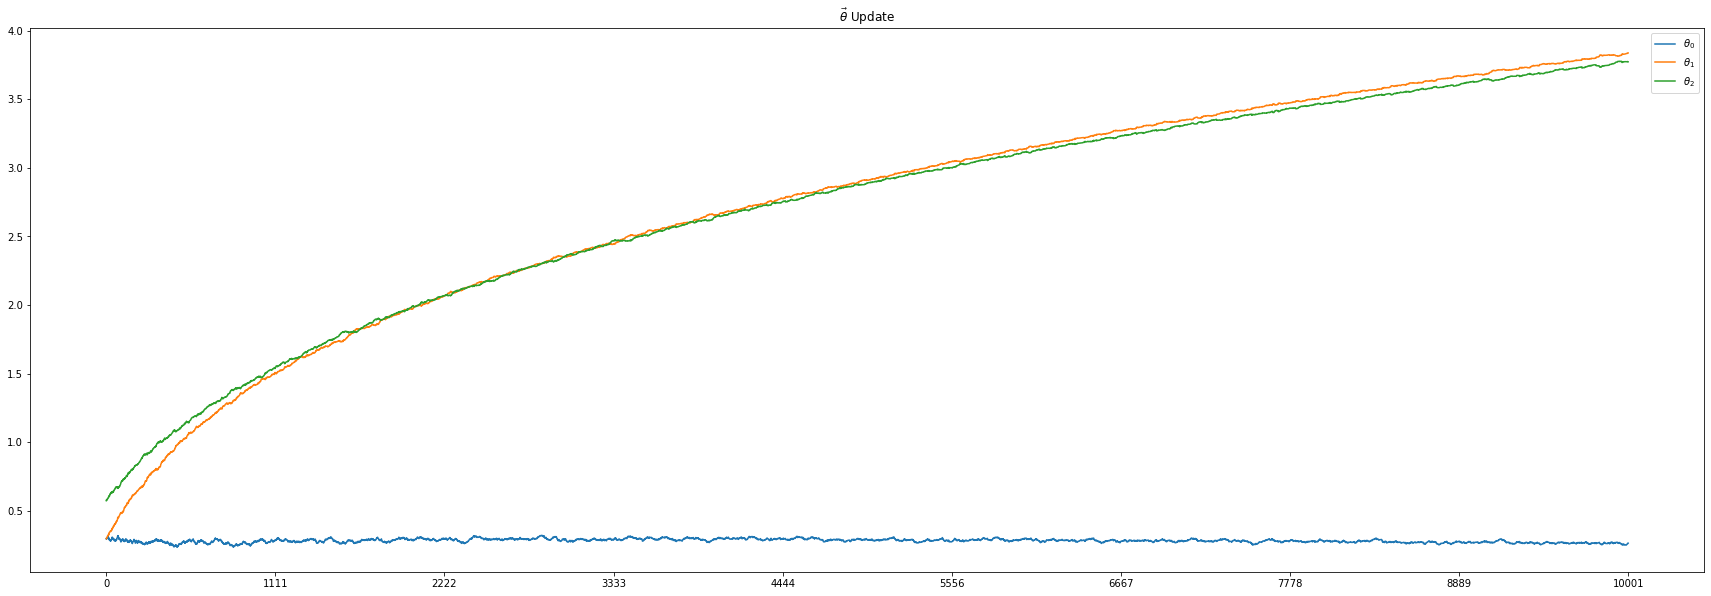

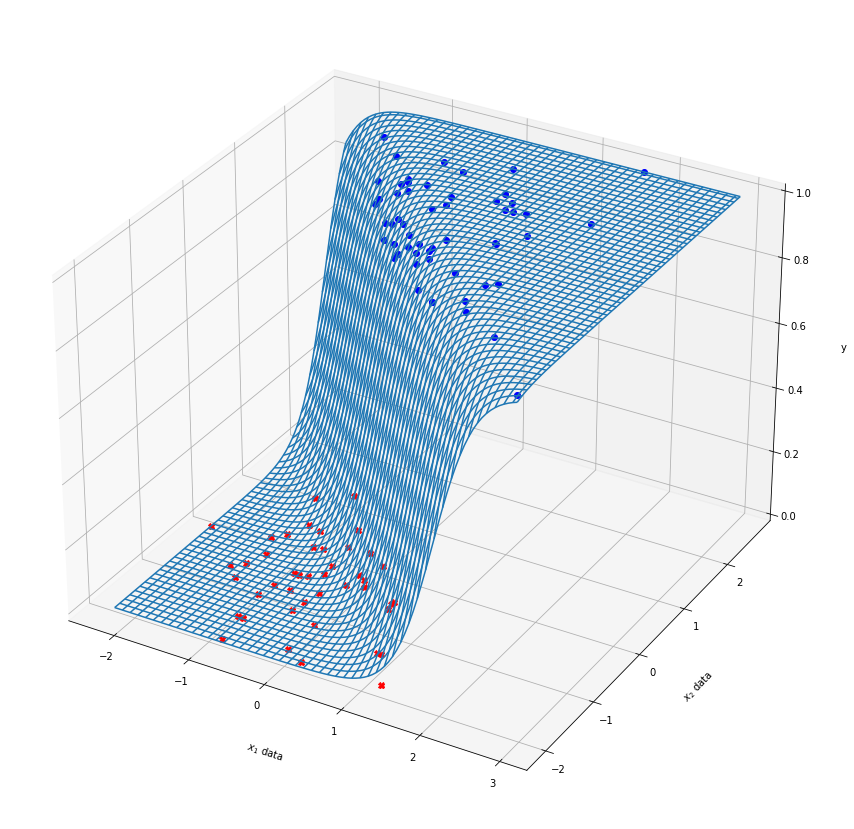

In [17]:
### Start
for epoch in range(epochs):
    np.random.shuffle(data)
    
    for data_idx in range(data.shape[0]):
        x, y =data[data_idx,:-1], data[data_idx, -1]
        
        z = affine.forward(x)
        pred = sigmoid.forward(z)
        l = BCE_loss.forward(y, pred)
        
        dpred = BCE_loss.backward()
        dz = sigmoid.backward(dpred)
        affine.backward(dz, lr)
        
        result_tracker()
### End
result_visualizer()
plot_classifier()